# Capstone Matrix Decomposition 


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Additional python packages
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import scipy.misc
from ggplot import *
import time
from sklearn.manifold import TSNE
import sklearn
from functions import * # Our functions

init_notebook_mode(connected=True)

## Load images and meta data

In [5]:

images=[]
names=[]
for root, dirs, files in os.walk('final_dataset'):
    for name in files:
        mypath = os.path.join(root,name)
        img=Image.open(mypath, mode='r')
        img = img.resize((128,128))
        arr = np.array(img).astype('uint8')
        images.append(arr)
        img.close()
        names.append(name.split('.')[0])

gene=[name.split('_')[0] for name in names]
days=[int(name.split('_')[1]) for name in names]
biofilm_number=[name.split('_')[2] for name in names]
dic={'label':names,'gene':gene,'days':days,'biofilm_number':biofilm_number}

df_all=pd.DataFrame.from_dict(dic)

## Lets look at some of the images

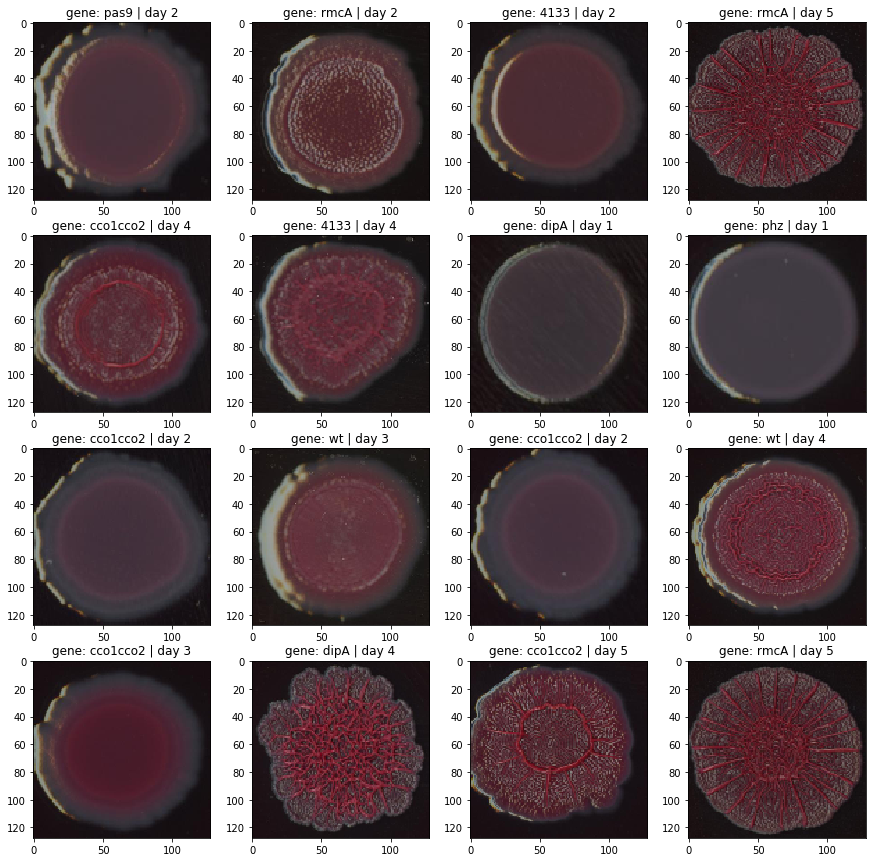

In [6]:
fig = plt.figure(figsize=(15,15))
n = 4

for i,s in enumerate(images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s)
        title = 'gene: %s | day %d' %(df_all['gene'][i],df_all['days'][i])
        plt.title(title)
    except:
        pass
plt.show()

### Process Images to find Wrinkles

In [101]:
def bf_size(image):
    a = image.max(axis=2)
    tmp = a > 30
    tmp_im = a * tmp
    return int(np.count_nonzero(tmp_im))
# def bf_size_vis(image):
#     a = image.max(axis=2)
#     tmp = a > 30
#     return a * tmp
def perc_wrinkled(img, biofilm_size):
    return round(np.count_nonzero(img)/biofilm_size,4)

In [111]:
processed_images=[get_classes(img,threshold_val=0, resize=128, n_clusters=2)[1] for img in images]
bfsizes = [bf_size(img) for img in images]
df_all['bf_size'] = bfsizes
perc_wrink = [perc_wrinkled(img,bfsizes[i]) for i,img in enumerate(processed_images)]
df_all['perc_wrink'] = perc_wrink

### Plots of processed images

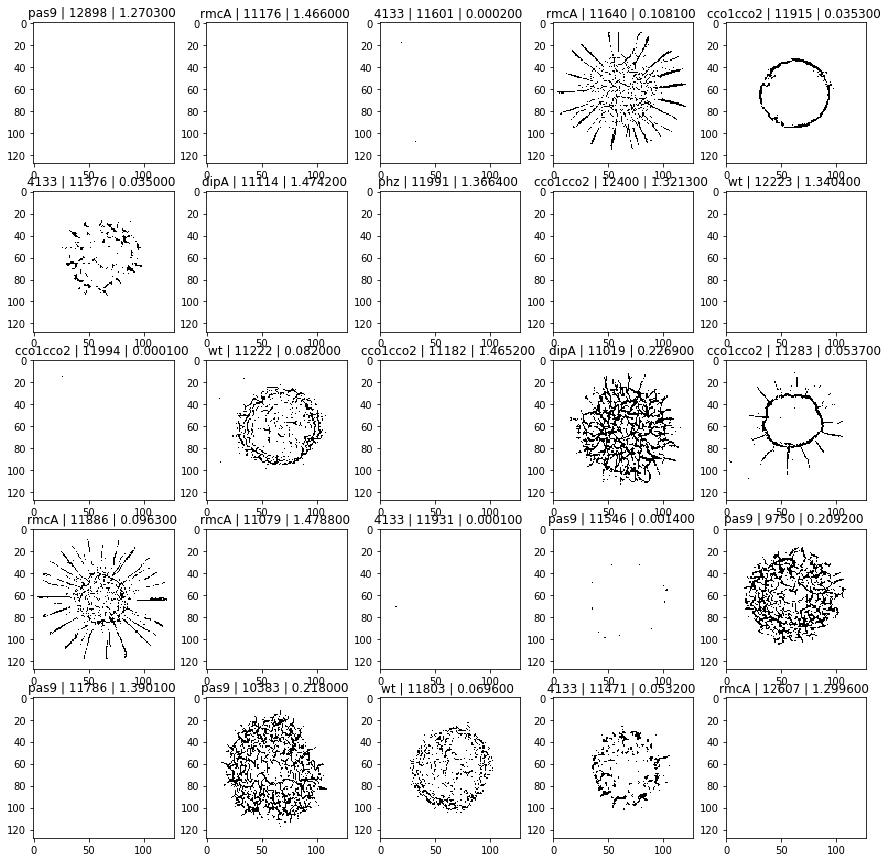

In [112]:
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(15,15))

n = 5

for i,s in enumerate(processed_images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s, cmap='binary')
        title = '%s | %d | %f ' %(df_all['gene'][i],df_all['bf_size'][i],df_all['perc_wrink'][i])
        plt.title(title)
    except:
        pass
plt.show()

## Pre-process images for decomp


### We filter images that have wrinkle percent less than 2%. This mostly eliminates all biofilms that are 1 and 2 days old. 

In [35]:
tsne_data = []
tsne_info = pd.DataFrame(columns=df_all.columns)
for i,img in enumerate(images):
    if perc_wrink[i] > .02 and perc_wrink[i] < 1.0:
        tsne_data.append(img)
        tsne_info = tsne_info.append(df_all.iloc[[i]])

In [8]:
# X = [x[:,:,0] for x in X]
X = [x.flatten() for x in tsne_data]
X = np.asarray(X)

In [9]:
labels = tsne_info['gene'].unique()
tsne_info['y'] = [int(np.where(labels==s)[0]) for s in tsne_info['gene']]
y = np.array(tsne_info['y'])

In [10]:
# feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

# df = pd.DataFrame(X,columns=feat_cols)
# df['label'] = df_all['gene']
# df['label'] = df['label'].apply(lambda i: str(i))

# X, y = None, None


# print('Size of the dataframe: {}'.format(df.shape))

In [11]:
X.shape

(532, 49152)

2018-11-25 20:17:09,561 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,570 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,580 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,589 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,599 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Automatically created module for IPython interactive environment
Dataset consists of 532 faces


2018-11-25 20:17:09,611 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,620 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,631 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,642 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,653 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,668 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:09,679 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

Extracting the top 16 Eigenfaces - PCA using randomized SVD...


2018-11-25 20:17:10,368 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,378 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,389 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,400 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,412 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,425 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:10,437 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 0.636s
Extracting the top 16 Non-negative components - NMF...


2018-11-25 20:17:11,478 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,489 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,503 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,515 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,527 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,539 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:11,550 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 0.921s
Extracting the top 16 Independent components - FastICA...


2018-11-25 20:17:13,263 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,272 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,283 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,293 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,301 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,312 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,321 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 1.595s


2018-11-25 20:17:13,457 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,467 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,478 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:17:13,489 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting the top 16 Sparse comp. - MiniBatchSparsePCA...


2018-11-25 20:18:51,068 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,077 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,088 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,099 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,109 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,120 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:51,130 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 97.562s
Extracting the top 16 MiniBatchDictionaryLearning...


2018-11-25 20:18:53,602 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,614 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,625 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,637 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,650 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,663 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:53,675 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 2.351s
Extracting the top 16 Cluster centers - MiniBatchKMeans...


2018-11-25 20:18:54,832 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,842 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,852 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,864 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,874 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,884 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:54,897 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 1.039s
Extracting the top 16 Factor Analysis components - FA...


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:238: ConvergenceWarning:

FactorAnalysis did not converge. You might want to increase the number of iterations.

2018-11-25 20:18:55,774 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:55,784 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:55,795 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:55,807 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:55,818 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:55,829 WARNING Clipping input data to the valid range for imshow with 

done in 0.750s


2018-11-25 20:18:55,981 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


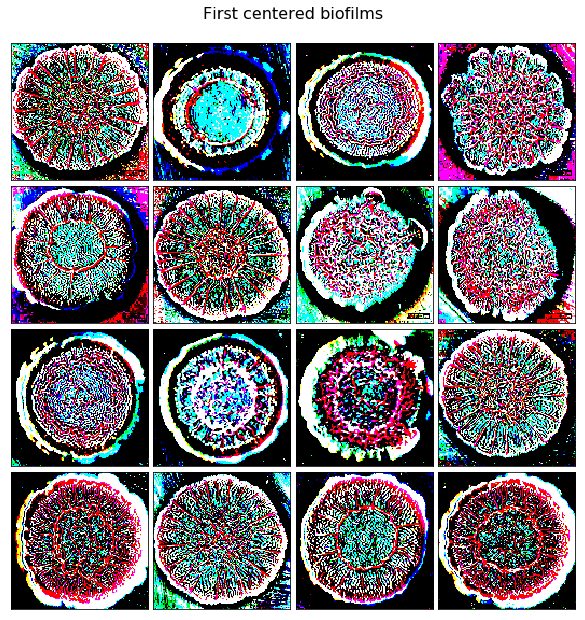

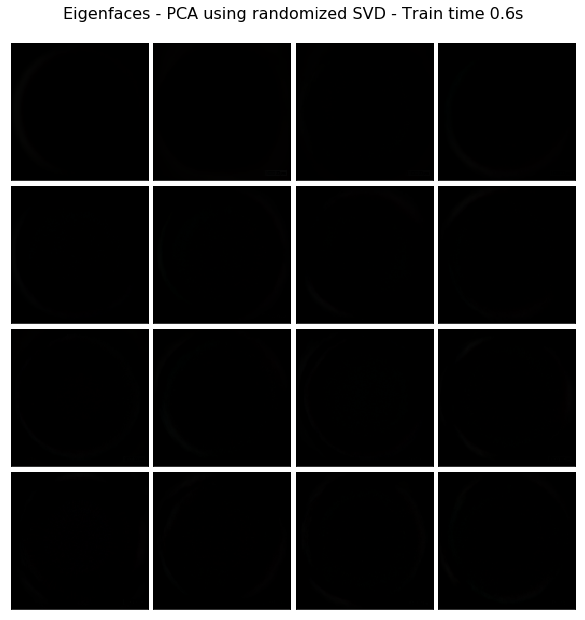

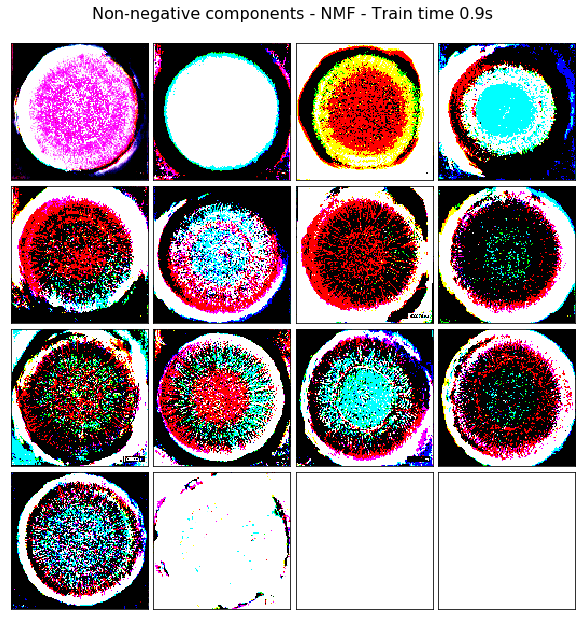

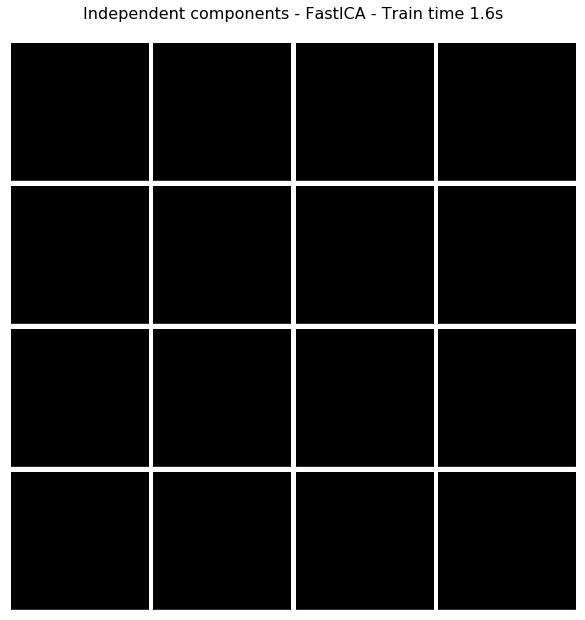

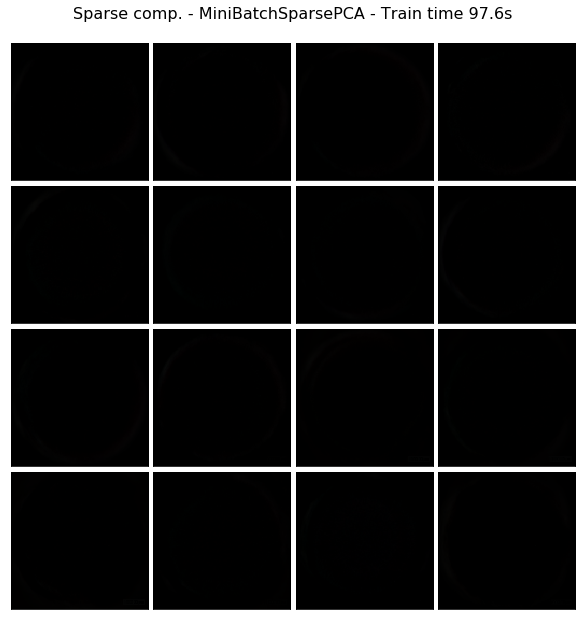

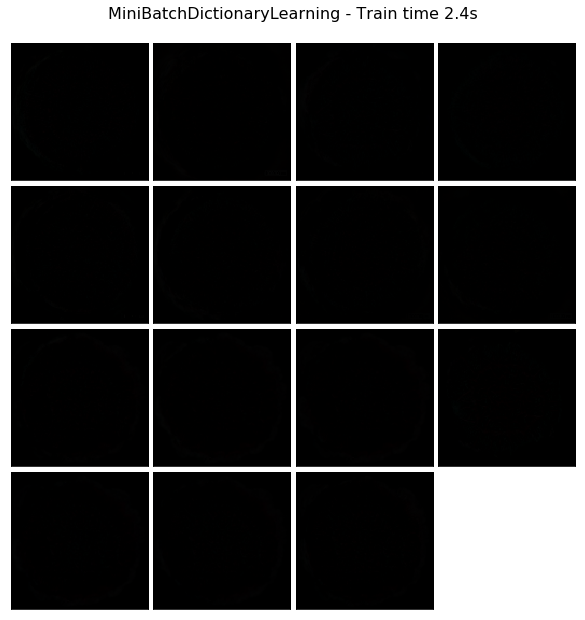

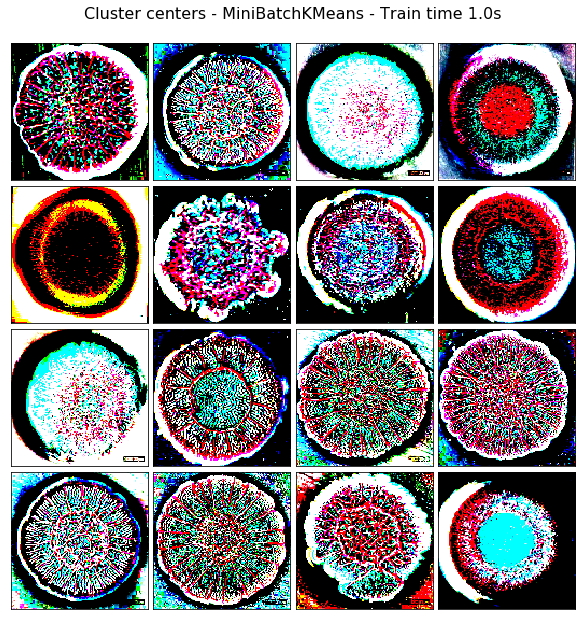

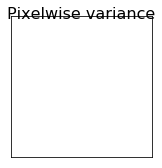

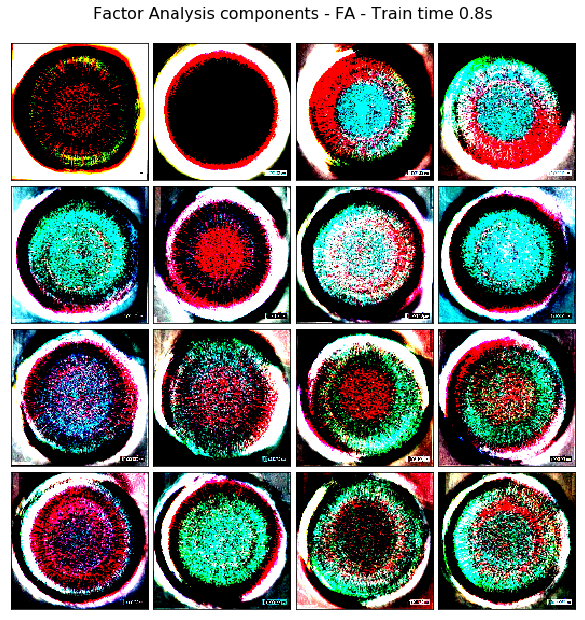

2018-11-25 20:18:57,911 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,920 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,929 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,938 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,947 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,956 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:18:57,966 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

Extracting the top 16 Dictionary learning...


2018-11-25 20:19:00,363 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,373 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,384 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,395 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,407 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,416 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:00,427 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 2.299s
Extracting the top 16 Dictionary learning - positive dictionary...
done in 2.115s
Extracting the top 16 Dictionary learning - positive code...


2018-11-25 20:19:04,573 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,582 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,591 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,601 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,610 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,621 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-11-25 20:19:04,630 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2018-1

done in 1.817s
Extracting the top 16 Dictionary learning - positive dictionary & code...
done in 1.738s


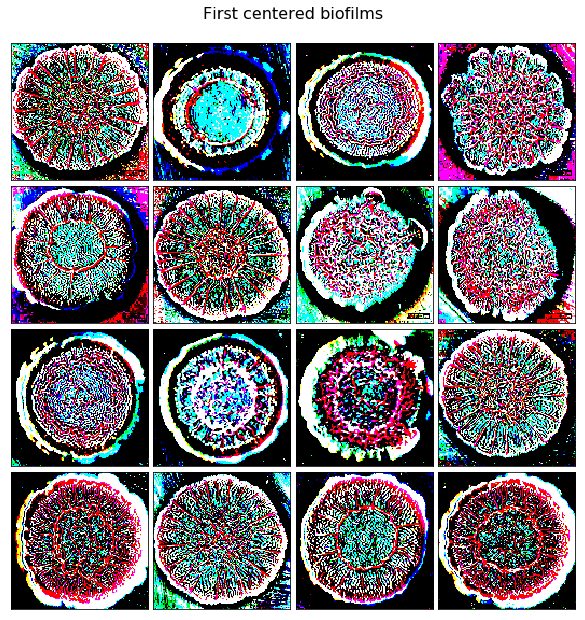

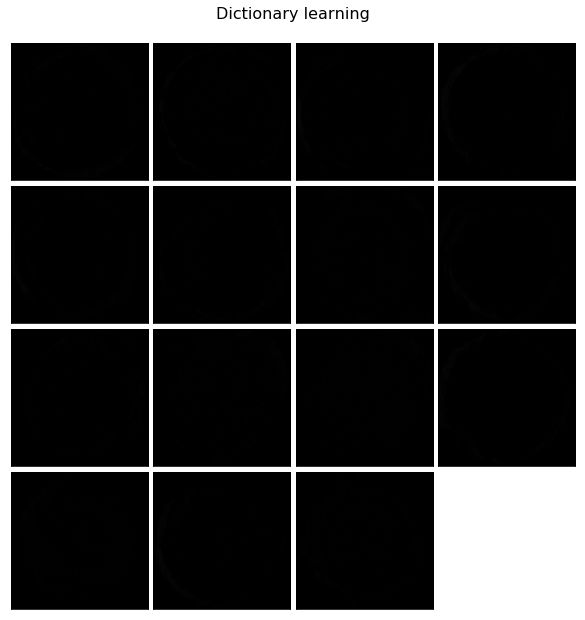

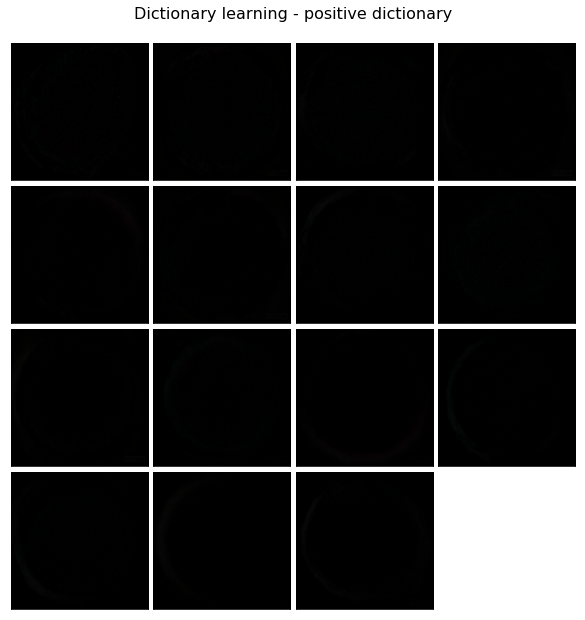

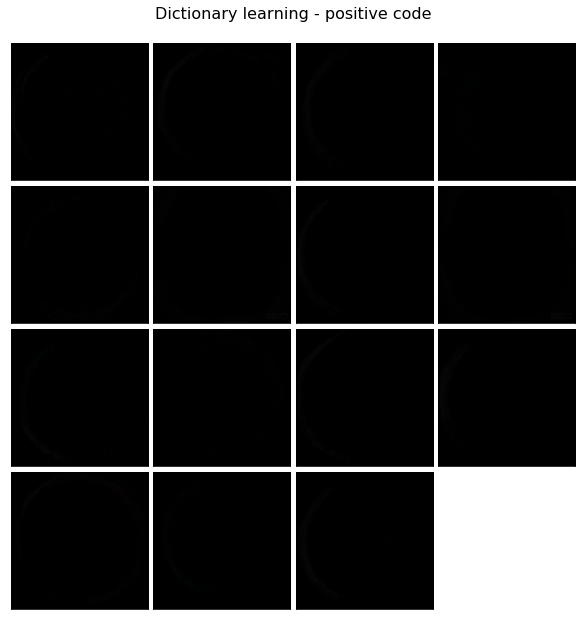

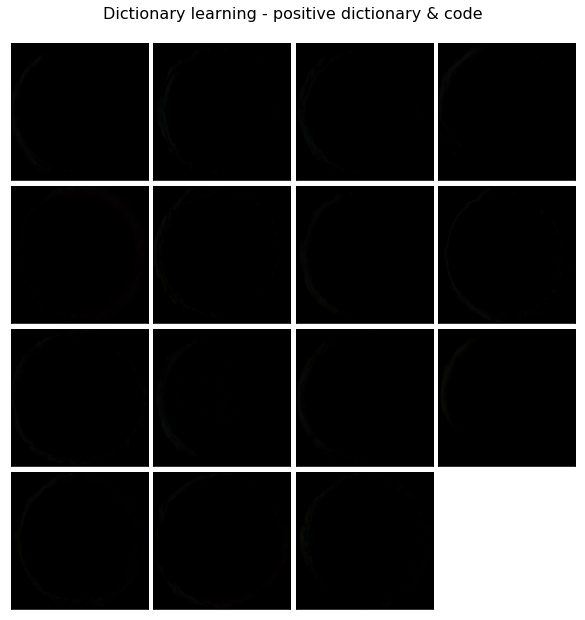

In [12]:
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 4, 4  
n_components = n_row * n_col
image_shape = (128, 128, 3)
rng = RandomState(0)

# #############################################################################
# Load faces data
# dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = X

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng,
                                      normalize_components=True),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered biofilms", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

# #############################################################################
# Various positivity constraints applied to dictionary learning.
estimators = [
    ('Dictionary learning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),
    ('Dictionary learning - positive dictionary',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True),
     True),
    ('Dictionary learning - positive code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_code=True),
     True),
    ('Dictionary learning - positive dictionary & code',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng,
                                                  positive_dict=True,
                                                  positive_code=True),
     True),
]


# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered biofilms", faces_centered[:n_components],
             cmap=plt.cm.RdBu)

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    components_ = estimator.components_
    plot_gallery(name, components_[:n_components], cmap=plt.cm.RdBu)

plt.show()

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 532
n_features: 49152
n_classes: 7
Extracting the top 50 eigenvectors from 399 biofilms
done in 0.798s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.115s
Fitting the classifier to the training set


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



done in 3.881s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting mutant type based on the test set
done in 0.004s
              precision    recall  f1-score   support

        rmcA       0.89      0.92      0.91        26
    cco1cco2       0.89      0.73      0.80        11
          wt       0.88      0.93      0.90        15
        dipA       0.62      0.80      0.70        20
        pas9       0.76      0.93      0.84        14
        4133       0.91      0.53      0.67        19
         phz       0.89      0.86      0.87        28

   micro avg       0.82      0.82      0.82       133
   macro avg       0.83      0.81      0.81       133
weighted avg       0.84      0.82      0.82       133

[[24  0  0  0  0  0  2]
 [ 0  8  0  2  0  1  0]
 [ 0  0 14 

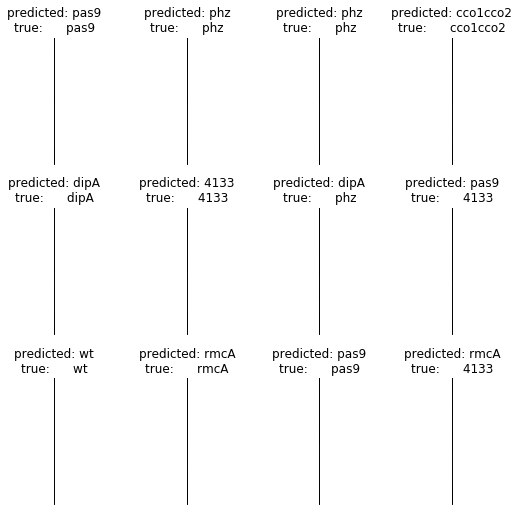

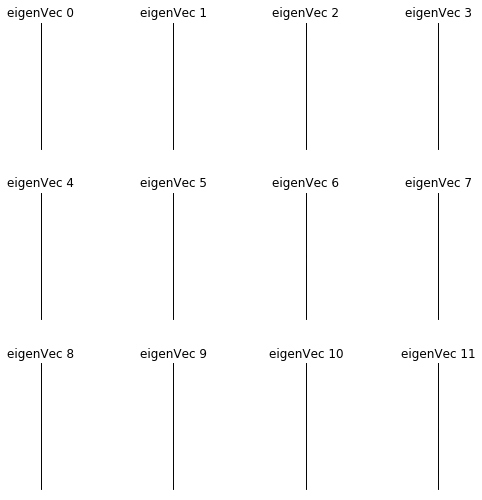

In [18]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

# lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h = X.shape
w = 1

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
n_features = X.shape[1]

# the label to predict is the id of the person
# y
target_names = labels
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenvectors from %d biofilms"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting mutant type based on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenVec %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()